<a href="https://colab.research.google.com/github/yedini/DL_tensorflow/blob/main/Part3_Lab03_MNIST_cnn_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

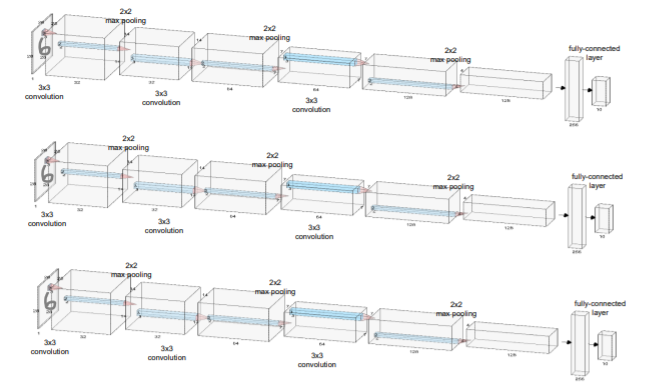
같은 데이터를 3개의 모델에 넣어서 각각 학습 후 앙상블 => 종합적으로 판단한다.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [ ]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.random.set_seed(777)


cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_emsemble'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

In [ ]:
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()    
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


Modeling - subclass 이용

In [ ]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10)
    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [ ]:
models = []  #모델이 여러개니까 리스트 만들기
num_models = 3
for m in range(num_models):
    models.append(MNISTModel())

In [ ]:

def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))
    return loss

    
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Accuracy

In [ ]:
def evaluate(models, images, labels):  #모델 리스트를 인자로 받음.
    predictions = np.zeros_like(labels)  #모델 3개에서 나오는 ouptput을 조ㅗㅇ합한 결과
    for model in models:
        logits = model(images, training=False)
        predictions += logits  # 다 더해서 값이 제일 큰 label로 선택한다.
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [ ]:
checkpoints = []  #모델별 체크포인트를 담은 리스트
for m in range(num_models):
    checkpoints.append(tf.train.Checkpoint(cnn=models[m]))

In [ ]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0    
    
    for images, labels in train_dataset:
        for model in models:  # 모델별 루프가 하나 더 생김
            #train(model, images, labels)
            grads = grad(model, images, labels)                
            optimizer.apply_gradients(zip(grads, model.variables))
            loss = loss_fn(model, images, labels)
            avg_loss += loss / num_models
        acc = evaluate(models, images, labels)
        avg_train_acc += acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(models, images, labels)        
        avg_test_acc += acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    
    for idx, checkpoint in enumerate(checkpoints):
        checkpoint.save(file_prefix=checkpoint_prefix+'-{}'.format(idx))

print('Learning Finished!')